In [44]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from category_encoders.target_encoder import TargetEncoder

import os

from xgboost import XGBClassifier

import matplotlib.pyplot as plt

In [4]:
data_path = 'data'
csv_fn = os.path.join(data_path, 'data_science_dataset_test_task.csv')

In [7]:
df = pd.read_csv(csv_fn)
df.head(5)

,Unnamed: 0,current_dt,user_id,scheduled_dt,root_order_id,gender,age,os_family,lt_user,hours_after_reg_buy,...,was_3ds,card_type,card_country_code,success_orders,not_success_orders,insufficients,root_gross,not_root_gross,old_model_probability,is_success
0,37,2019-05-12 05:40:15.355095,13801584,2019-06-09 00:00:00.000000,96601292,f,43,11,2,0,...,0,2.0,154,2,0,0,29.17,6.81,0.512364,1
1,45,2019-06-07 08:10:15.982701,16144816,2019-06-09 00:00:00.000000,116843195,f,25,11,4,76,...,0,2.0,3,2,1,1,0.47,0.46,0.133615,1
2,46,2019-06-07 08:10:15.982701,16467614,2019-06-09 00:00:00.000000,116847635,f,45,11,1,0,...,0,2.0,1,2,1,0,0.48,6.67,0.481923,0
3,47,2019-06-08 03:10:13.314904,16467614,2019-06-09 00:00:00.000000,116847635,f,45,11,2,0,...,0,2.0,1,2,1,0,0.48,6.67,0.485032,0
4,51,2019-06-07 08:10:15.982701,16482460,2019-06-09 00:00:00.000000,116953235,m,45,11,1,0,...,0,2.0,1,1,1,1,0.48,0.00,0.114275,0


In [50]:
def encode_categorical(train, val, target):
    train['gender'] = train.gender.map(lambda x: 0 if x == 'm' else 1)
    val['gender'] = train.gender.map(lambda x: 0 if x == 'm' else 1)
    
    train['country_code'] = train.country_code.map(lambda x: 'country_code' + str(x))
    val['country_code'] = val.country_code.map(lambda x: 'country_code' + str(x))
    
    train['phone'] = train.phone.map(lambda x: 'phone' + str(x))
    val['phone'] = val.phone.map(lambda x: 'phone' + str(x))
    
    train['currency_id'] = train.currency_id.map(lambda x: 'currency_id' + str(x))
    val['currency_id'] = val.currency_id.map(lambda x: 'currency_id' + str(x))
    
    train['last_response_code'] = train.last_response_code.map(lambda x: 'last_response_code' + str(x))
    val['last_response_code'] = val.last_response_code.map(lambda x: 'last_response_code' + str(x))
    
    train['bank'] = train.bank.map(lambda x: 'bank' + str(x))
    val['bank'] = val.bank.map(lambda x: 'bank' + str(x))
    
    train['card_country_code'] = train.card_country_code.map(lambda x: 'card_country_code' + str(x))
    val['card_country_code'] = val.card_country_code.map(lambda x: 'card_country_code' + str(x))
    
    encoder = TargetEncoder()
    train = encoder.fit_transform(train, target)
    val = encoder.transform(val)
    return train, val

In [51]:
cols_to_drop = ['Unnamed: 0', 'current_dt', 'user_id', 'scheduled_dt', 'root_order_id', 'old_model_probability']

df_drop = df.drop(cols_to_drop, axis=1)

x_train, x_val, y_train, y_val = train_test_split(df_drop.drop(['is_success'], axis=1),
                                                  df_drop['is_success'], 
                                                  test_size=0.2, 
                                                  random_state=42)

x_train_enc, x_val_enc = encode_categorical(x_train, x_val, y_train)

C:\Users\sqrte\.conda\envs\genesis\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [53]:
model = XGBClassifier()
model.fit(x_train_enc, y_train)
predictions = model.predict(x_val_enc)

C:\Users\sqrte\.conda\envs\genesis\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:54:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [54]:
precision = precision_score(predictions, y_val)
recall = recall_score(predictions, y_val)
f1 = f1_score(predictions, y_val)
roc_auc = roc_auc_score(predictions, y_val)

print('\n----------------------------')
print('Model precision: ', precision)
print('Model recall: ', recall)
print('Model f1: ', f1)
print('Model roc_auc: ', roc_auc)


----------------------------
Model precision:  0.1749645725082664
Model recall:  0.6042414355628059
Model f1:  0.2713553113553113
Model roc_auc:  0.712188066863849


In [22]:
precision = precision_score(predictions, y_val)
recall = recall_score(predictions, y_val)
f1 = f1_score(predictions, y_val)
roc_auc = roc_auc_score(predictions, y_val)

print('\n----------------------------')
print('Model precision: ', precision)
print('Model recall: ', recall)
print('Model f1: ', f1)
print('Model roc_auc: ', roc_auc)


----------------------------
Model precision:  0.16461974492205952
Model recall:  0.6143134144191785
Model f1:  0.25965801139962
Model roc_auc:  0.7165229628597846


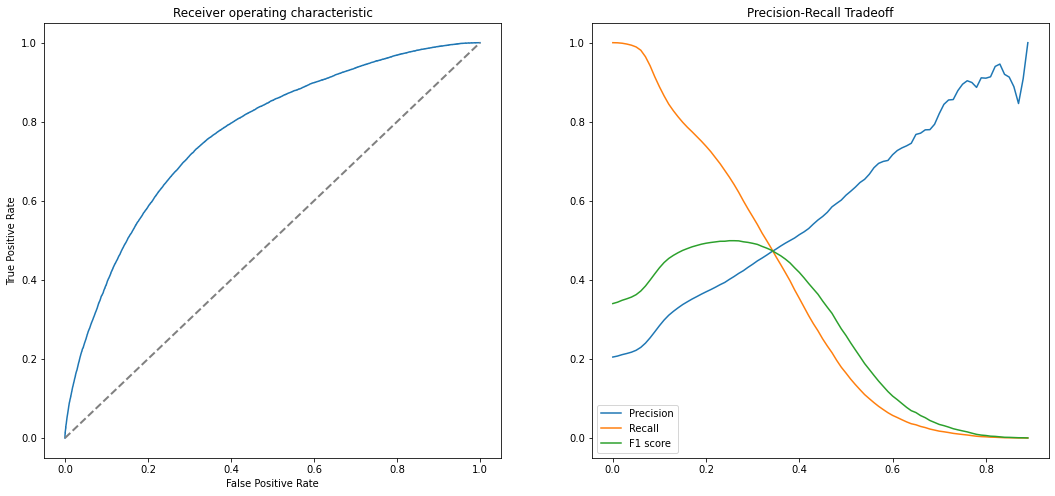

In [40]:
predictions_prob = model.predict_proba(x_val_enc)

fpr, tpr, _ = roc_curve(y_val, predictions_prob[:,1])

fig, ax = plt.subplots(1, 2, figsize=(18, 8))

lw = 2
ax[0].plot(fpr, tpr)
ax[0].plot([0, 1], [0, 1], color='gray', lw=lw, linestyle='--')
ax[0].set_title('Receiver operating characteristic')
ax[0].set_xlabel('False Positive Rate')
ax[0].set_ylabel('True Positive Rate')

precisions = []
recalls = []
f1s = []

x = np.arange(0, 0.9, 0.01)
for threshold in x:
    model_predictions = np.array(predictions_prob > threshold, dtype='int8')
    precision = precision_score(y_val, model_predictions[:,1])
    recall = recall_score(y_val, model_predictions[:,1])
    f1 = f1_score(y_val, model_predictions[:, 1])
    
    precisions.append(precision)
    recalls.append(recall)
    f1s.append(f1)

ax[1].set_title('Precision-Recall Tradeoff')
ax[1].plot(x, precisions, label='Precision')
ax[1].plot(x, recalls, label='Recall')
ax[1].plot(x, f1s, label='F1 score')
ax[1].legend()
plt.show()